# Viterbi Alignment

Viterbi Alignment and Trellis based Recognition 

In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
import torch
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm
from pyspch.stats import GMM, Prob
import pyspch.nn

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

from x_utils import plot_probs, get_test_file



In [4]:
#@title Auxiliary functions 
# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

In [5]:

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

In [6]:
def make_graph(phn_seq,phn_set,l2r=1.0,eps=0.0,skip=0.0,style="VIT"):
    ''' 
    makes an HMM Graph to do recognition or alignment
    A transition matrix for a phone sequence (phn_seq) is created, all belonging to the alphabet phn_set
    Transition probabilities are mainly 0's and 1's 
    
    - default is make a left-to-right graph of phn_seq
        i.e. probability=1.0 on self_loop and L2R arcs
        
    - l2r:  probability on L2R arcs
    - eps:  probability on all ergodic arcs 
    - skip: probability for the skip arcs

    The end result needs to be normalized to make true probabilities out of it
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')

    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    if style == "VIT":
        init_mat = np.zeros(n_seq,dtype='float32')
        init_mat[0] = 1.0
        end_states = np.array([n_seq-1])
        # add left-to-right arcs
        for i in range(n_seq-1):
            trans_mat[i,i+1] = np.maximum(l2r,trans_mat[i,i+1])
            if i+2 < n_seq:
                trans_mat[i,i+2] = np.maximum(eps,skip)
                
    elif style == "RECO":
        init_mat = np.ones(n_seq,dtype='float32')
        end_states = np.arange(n_seq)

    # set eps probabilities
    trans_mat = np.maximum(eps,trans_mat)
    init_mat = np.maximum(eps,init_mat)
    
    return(obs_indx,trans_mat,init_mat,end_states)

## 1. Load the Observation Model

### Feature Extraction
MFCC26=  MFCC13 + Deltas + mean-variance normalization, (defined by feature_args).
### GMM models
**S41_D26_G64_FULL_1.pkl**  G64=64 Gaussians, S41= 41 classes/states, D26 = 26 dim features, (FrameRecog: 56%)

In [7]:
# task setup
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# define feature extraction: MFCC13 + delta's + delta_delta's mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
gmm_model = Spch.load_data("S41_D26_G64_FULL_1.pkl",root=gmm_root)  # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
gmm_nftrs = 26  # only use 26 features with gmms
phn_set= gmm_model.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

In [8]:
#
# read the DNN model
#
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
model_path = 'models/default/mfcc13dd2mv/N5s2/' 
#model_path = 'models/default/mfcc13dd2mv/N0s1/' 

# read checkpoint 
model_fobj = pyspch.read_fobj(timit_root + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}

setup = dotdict(setup)
model.to(device)

FFDNN(
  (net): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=768, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=768, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=41, bias=True)
  )
)

In [24]:
# an sklearn style wrapper our torch DNN models
class DNN_model():
    def __init__(self,priors=None,setup=None,model=None,device="cpu"):
        self.prob_style = "Posteriors"
        self.class_prior_ = priors
        self.setup = setup
        self.model = model
        self.device = device
        
    def predict_proba(self,X):
        # X comes in as [n_samples, n_features], but splice_frames asssumes [n_features,n_samples]
        X_dnn = pyspch.sp.splice_frames(X.T,self.setup.sampler_args['N'], self.setup.sampler_args['stride'])
        print(X_dnn.shape)
        # posteriors 
        X_t = torch.tensor(X_dnn).T.float().to(self.device)
        yp_t = self.model(X_t) # log probs
        yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs
        proba = yp_t.cpu().detach().numpy()
        return(proba)
        
    def predict_prob(self,X):
        proba = self.predict_proba(X)
        if self.class_prior_ is None: probs = proba
        else:
            probs = probs/ self.class_prior_
            probs = probs / np.sum(probs,axis=1,keepdims=True)
        return ( probs )
        
    def predict_log_prob(self,X):
        Xp = self.predict_prob(X)
        return Spch.logf( Xp ) 

def proba_2_prob(probs,priors=None):
    ''' compute normalized likelihoods (sum = 1) from posterior probabilities
    '''
    if priors is None: return(probs)
    else:
        probs = probs/ priors
        probs = probs / np.sum(probs,axis=1,keepdims=True)
    return ( probs )

# the TIMIT phone class priors have been stored in the GMM model
# and be used with the DNN to convert from posteriors to (normalized) likelihoods 
dnn_model = DNN_model(setup=setup, model=model, priors= gmm_model.class_prior_, device=device)    
dnn_nftrs = 39

## 2. Run Example File

The following cells take care of
1. loading test sample and segmentations
2. spg and feature computation
3. set some focus time to highlight one or a couple of words in a full sentence

The first cell will load our prototypical "friendly computers"; the second cell loads one of a few preselected TIMIT test files.
Just execute one of these cells

In [25]:
# loading a test file (non-TIMIT)
file_id =  'demo/friendly'
focus_times = np.array([0.48,1.04])
type = None

In [102]:
# loading a test file (non-TIMIT)
file_id =  'misc/bad_bead_booed'
focus_times = np.array([1.5,2.1])
type = None

In [103]:
# loading a test file (non-TIMIT)
file_id =  'digits/5752'
focus_times = np.array([0.,1.0])
type = None

In [11]:
# loading a TIMIT test file
# choose an example from 0 .. 4 
file_id = 3
timit_focus_times = [ [2.10,3.07], [.12,.88], [.05,.51], [0.,.85], [1.26,2.65] ] # [0.,1], [0.,1], [0.,1.]]
focus_times = np.array(timit_focus_times[file_id])
type = "TIMIT"

friendly computers     t0   t1        seg
0 0.01 0.44   friendly
1 0.49 1.04  computers


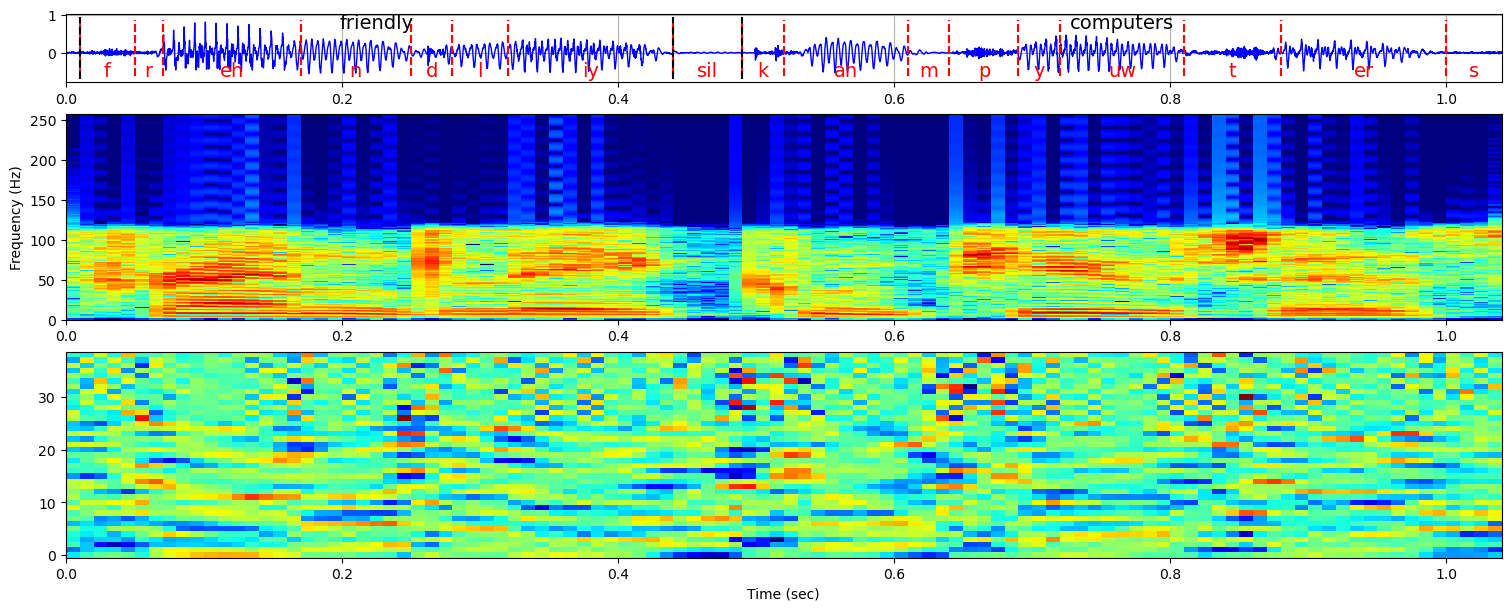

In [26]:
# load all the data
wavdata, sr, spgdata, ftrs, txt, seg_wrd, seg_phn = get_test_file(file_id,feature_args=feature_args,type=type)
print(txt,seg_wrd)
transcript = seg_phn['seg'].tolist()
# select a time segment to focus on and find corresponding phones / transcription
labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
shift=feature_args['f_shift']
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
##############################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,
                                  sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=0, ypos=.1, color='r',size=14) 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='k',size=14) 
display(fig)
display(Audio(data=wavdata,rate=sr))

# Time & Segment selection for plots 

In [12]:
#focus_times = np.array([0.51,.92])
frames= (focus_times/shift).astype('int')
samples = (focus_times*sr).astype('int')
sample_sel = slice(samples[0],samples[1])
frame_sel = slice(frames[0],frames[1])
seg_sel = seg_phn[(seg_phn['t0']<frames[1]*shift) & (seg_phn['t1']>frames[0]*shift)]
state_sel = np.array(seg_sel.index.tolist())
transcript_sel = np.array(transcript)[state_sel]

### Frame Probabilities

In [58]:
model = gmm_model
nftrs = 26
#model = dnn_model
#nftrs = 39
X=ftrs[:nftrs,:].T
frame_proba = model.predict_proba(X)
frame_ll = model.predict_log_prob(X)
obs_prob = proba_2_prob(frame_proba,priors=gmm_model.class_prior_)
obs_logprob = np.log(obs_prob)   #same as frame_ll but computed from posteriors and normalized

In [54]:
frame_ll[0]

array([-62.771, -54.7  , -38.204, -59.184, -58.24 , -51.632, -49.896,
       -37.033, -39.14 , -30.699, -32.682, -50.247, -50.852, -44.054,
       -60.632, -31.91 , -39.617, -35.981, -48.162, -53.564, -37.389,
       -35.878, -49.683, -42.938, -59.479, -58.4  , -33.318, -51.701,
       -32.655, -38.587, -32.983, -32.204, -60.818, -56.354, -31.773,
       -46.947, -50.672, -31.527, -45.499, -34.256, -33.208])

In [57]:
obs_logprob[0]-29.642

array([-62.771, -54.699, -38.204, -59.183, -58.24 , -51.632, -49.896,
       -37.033, -39.139, -30.699, -32.682, -50.247, -50.852, -44.054,
       -60.632, -31.91 , -39.616, -35.981, -48.162, -53.564, -37.389,
       -35.878, -49.683, -42.938, -59.478, -58.4  , -33.318, -51.701,
       -32.655, -38.587, -32.983, -32.204, -60.818, -56.354, -31.773,
       -46.947, -50.672, -31.527, -45.499, -34.256, -33.208])

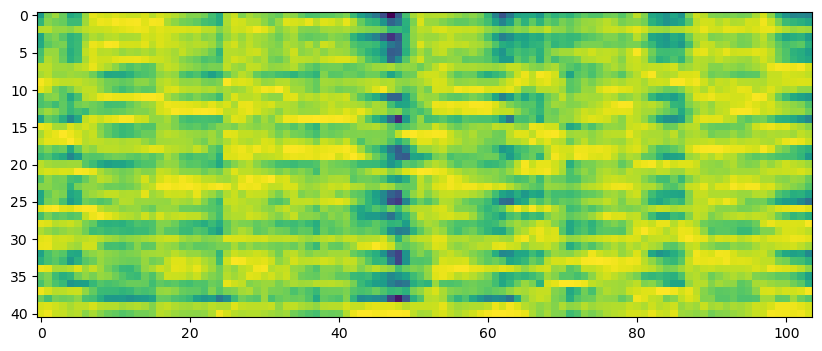

In [64]:
plt.imshow(obs_logprob.T,norm="linear")

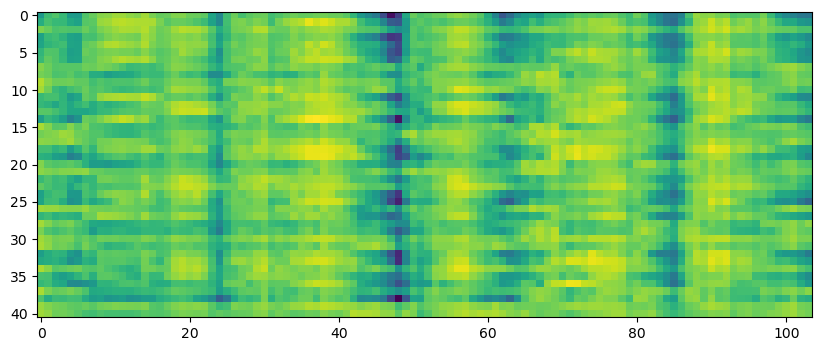

In [63]:
plt.imshow(frame_ll.T,norm="linear")

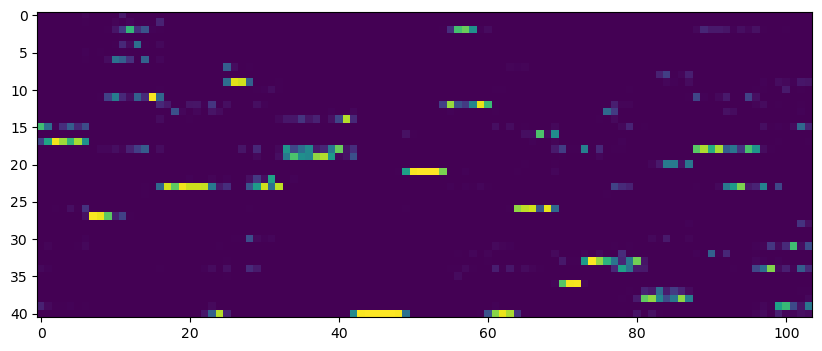

In [32]:
plt.imshow(obs_prob.T)

In [43]:
obs_prob[0], frame_proba[0]

(array([1.285e-07, 4.262e-07, 1.415e-06, 9.091e-10, 5.187e-08, 1.067e-05,
        2.043e-06, 2.599e-05, 3.146e-08, 5.961e-07, 2.695e-05, 1.146e-09,
        4.360e-07, 1.799e-08, 7.554e-09, 6.945e-01, 5.189e-06, 1.921e-01,
        2.370e-09, 4.404e-09, 3.024e-09, 3.850e-06, 2.482e-10, 2.362e-08,
        7.812e-08, 1.699e-09, 1.646e-04, 6.244e-07, 1.797e-05, 3.679e-07,
        3.600e-07, 7.258e-05, 2.618e-09, 1.837e-09, 2.273e-02, 1.312e-08,
        7.026e-09, 1.697e-07, 1.465e-08, 9.027e-02, 3.433e-05]),
 array([1.225e-07, 6.423e-07, 1.409e-06, 8.418e-10, 1.547e-08, 1.404e-05,
        1.786e-06, 2.527e-06, 5.695e-09, 1.237e-07, 7.294e-06, 1.024e-09,
        2.757e-07, 3.896e-09, 5.564e-09, 4.033e-01, 7.961e-07, 6.912e-02,
        5.080e-09, 7.046e-09, 5.434e-10, 2.455e-06, 2.747e-10, 2.823e-08,
        5.336e-08, 4.766e-10, 4.807e-05, 6.291e-07, 3.863e-05, 2.417e-07,
        2.630e-07, 1.267e-05, 2.715e-10, 1.236e-09, 6.957e-03, 6.991e-09,
        2.023e-09, 1.359e-07, 4.539e-10, 5.204e

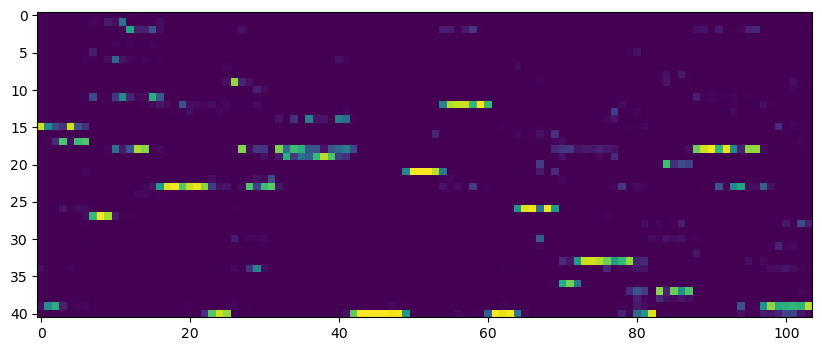

In [29]:
plt.imshow(np.exp(frame_ll.T))

### Frame Recognition

In frame recognition each feature vector is treated independently.  It consists of 2 simple steps:   
1. compute the class probabilities for each feature vector
2. recognize by finding the maximum amongst all classes

In [67]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
# evaluate frame based recognition wrt. manual segmentations
y_frame_idx = np.argmax(frame_proba, axis=1)
#y_frame_idx = np.argmax(obs_prob, axis=1)
y_frame_lab = [phn_set[i] for i in y_frame_idx]
t = np.arange(len(y_frame_lab))*shift+0.5*shift
y_frame_ldf = pd.DataFrame({'t':t,'lbl':y_frame_lab})
y_frame_seg = pyspch.lbls2seg(y_frame_lab)
n_corr = np.sum([y_frame_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)))
#

Frame Recognition Rate (for full utterance): 21.15 %


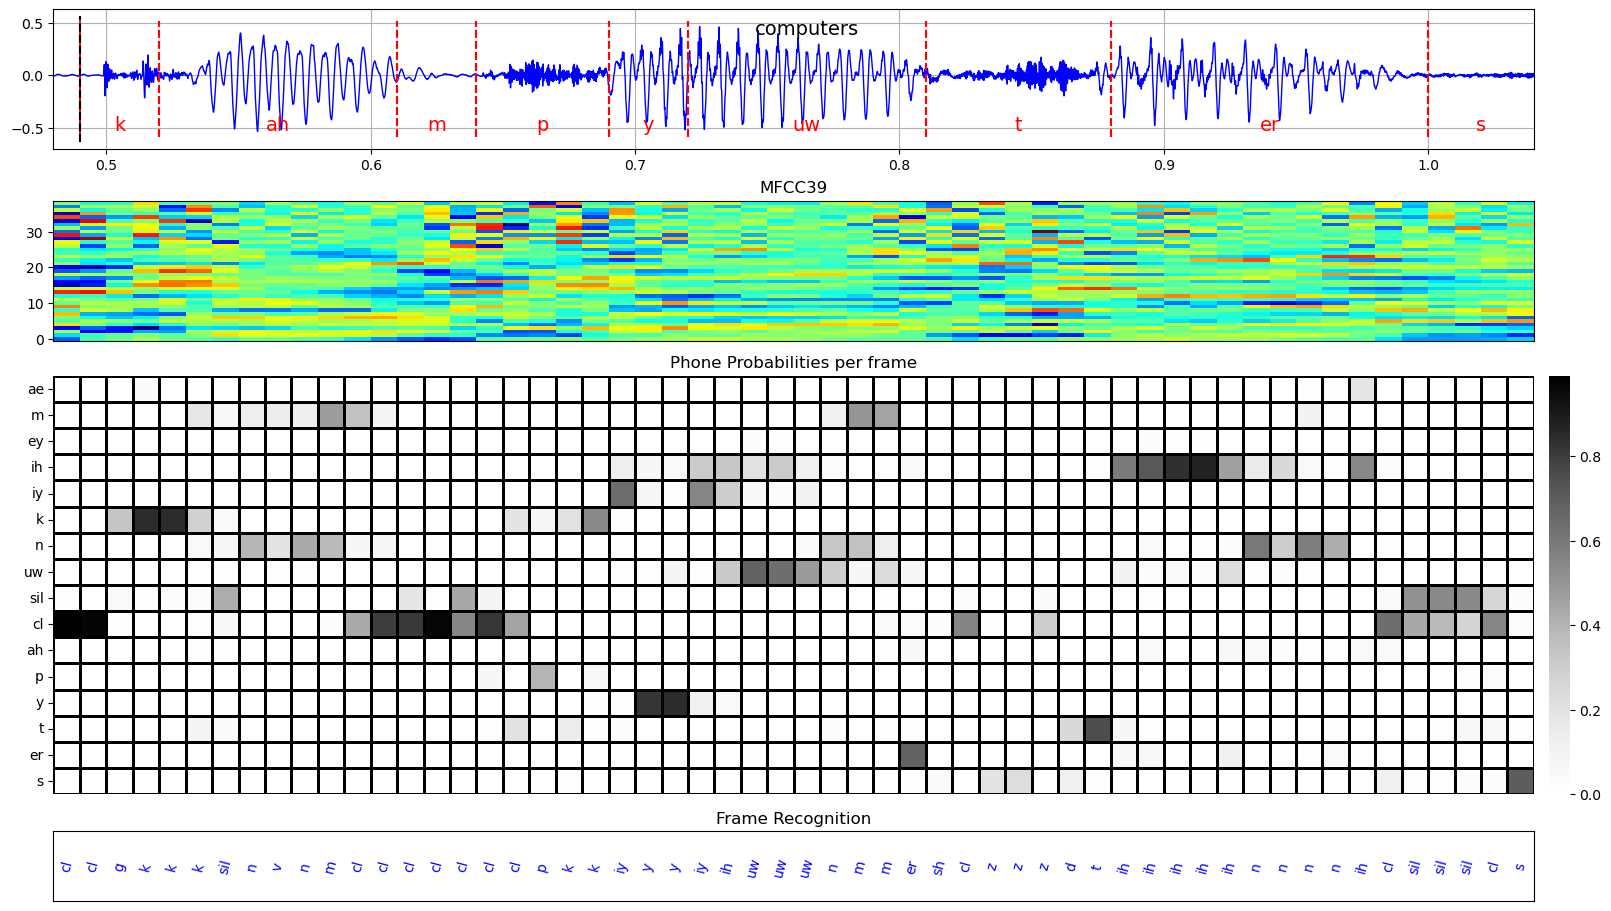

In [68]:
# show the outputs of the most likely phones and at least all phones in the transcript, resorted for order in alphabet
top_k = 10
indx_sel = np.argsort(np.sum(frame_proba,axis=0))[::-1][0:top_k]
indx_sel = np.sort(indx_sel)
phn_sel = [phn_set[i] for  i in indx_sel]
phn_sel,indx_sel = select_phones_idx((phn_sel,transcript_sel),phn_set,SORTED=False)
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,.5],
            sample_rate=sr, figsize=(16,9), frames=frames, img_ftrs=[None,None],img_labels=[None,None])

(iax_wav, iax_ftr, iax_prob, iax_frame) = (0,1,2,3)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r',size=14) 
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
fig.axes[iax_ftr].set_title("MFCC39")
fig.axes[iax_ftr].set_xticks([])
plot_probs(frame_proba[frame_sel,indx_sel], phn_sel,fig=fig, cmap='Greys',iax=iax_prob, style="img",title="Phone Probabilities per frame") 
#fig.axes[iax_prob].set_ylabel('Frame Probabilities')
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10,txtargs={'rotation':75},title="Frame Recognition")

#fig.axes[iax_frame].axis('off')
fig.axes[iax_frame].set_xticks([])
fig.axes[iax_frame].set_xlabel("")
display(fig)

### Viterbi Alignment
For a Viterbi alignment we use a Trellis setup.
If we want to align our data with a given transcription, then we may enforce a strict left-to-right arrangement of HMM states corresponding to the transcription.

It consists of 3 steps:   
1. compute the class probabilities for each feature vector (as in frame recognition)
2. complete the trellis (left to right) with the state sequence on the vertical and frame likelihoods on the horizontal axis .  Note that the HMM model uses 'likelihoods' and '(posterior) probabilities'
3. Find the Viterbi alignment by backtracking on the trellis

In the end we compute the frame level agreement with our given 'manual' alignment.  This will likely NOT be 100%.  But this is not problematic.
The manual alignment is probably not perfect.  Overall the obtained alignment is of high quality.

In [72]:
l2r = 1
skip=0
obs_indx, trans_mat,init_mat,end_states = make_graph(transcript,phn_set,l2r=l2r,skip=skip)
###hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=model,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
obs_model = Prob(style="logProbs",priors=None) #gmm_model.class_prior_)
hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=obs_model,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# setting to log-probabilities gives a better impression of relevant ranges
hmm1.set_probstyle('log')
#
#trellis1=libhmm.Trellis(hmm1,Normalize=True)
#trellis1.viterbi_pass(X);
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(obs_logprob)
# recognize from the trellis
y_vit_lbl = hmm1.states[trellis1.backtrace()]
y_vit_ldf = pd.DataFrame({'t':t,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Frame level agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

Frame level agreement with manual alignment: 78.85 %


In [70]:
# does not work properly with the DNN models ??
l2r = 1
skip=0
obs_indx, trans_mat,init_mat,end_states = make_graph(transcript,phn_set,l2r=l2r,skip=skip)
hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=model,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# for computational stability we prefer to use log-probs in a trellis (though not so relevant with subsequent normalization)
hmm1.set_probstyle('log')
# we normalize each column in the trellis
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(X);
# recognize from the trellis
y_vit_lbl = hmm1.states[trellis1.backtrace()]
y_vit_ldf = pd.DataFrame({'t':t,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Frame level agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

Frame level agreement with manual alignment: 78.85 %


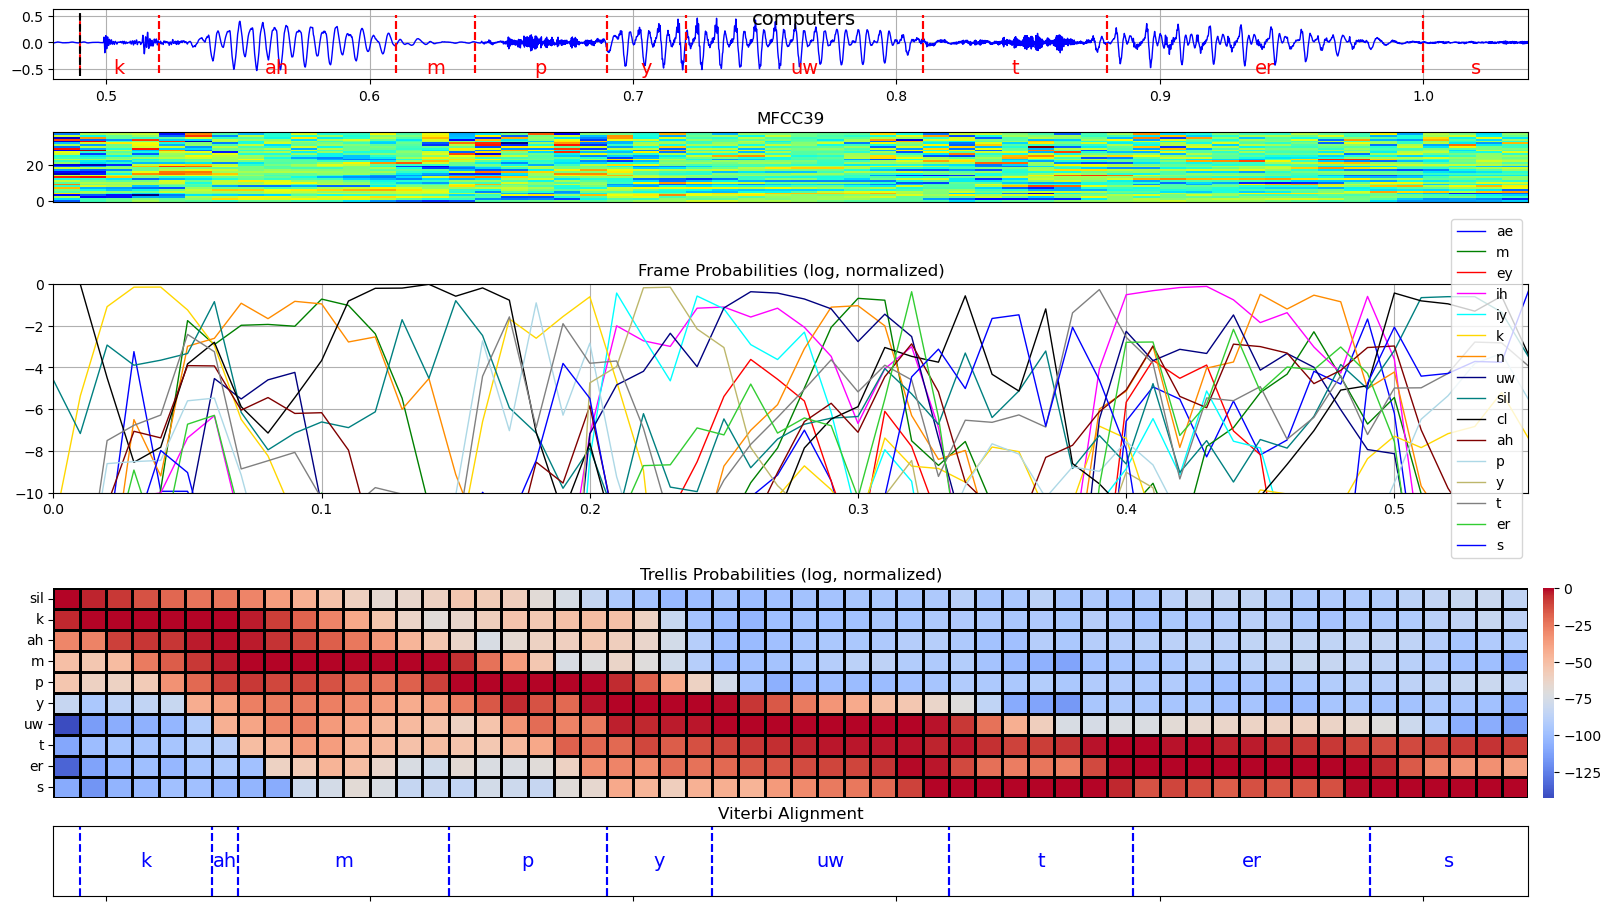

In [73]:
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,1],
            frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftr, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r',size=14) 
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
fig.axes[iax_ftr].set_xticks([])
fig.axes[iax_ftr].set_title("MFCC39")
#
log_probs = np.log(frame_proba) 
plot_probs(log_probs[frame_sel,indx_sel],phn_sel,fig=fig, cmap='Greys',iax=iax_prob,title="Frame Probabilities (log, normalized)",
          style="line",yrange=[-10.,0]  )#,vmin=-10) 
#
trel_probs = trellis1.probs
plot_probs(trel_probs[frame_sel,state_sel],fig=fig,cmap='coolwarm',labels=transcript_sel,iax=iax_trel,title="Trellis Probabilities (log, normalized)",
          style="img") # style="line" ,yrange=[-100,0])#,vmin=-100., annot=False)
#fig.add_seg_plot(y_vit_ldf,iax=iax_vit,ypos=.75,color='#000',size=10,txtargs={'rotation':75})
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.5,color='#00F',size=14,title="Viterbi Alignment")
#fig.axes[iax_vit].set_ylabel('Alignment')
#
display(fig)

### Phone Recognition 
We can use our trellis to do recognition as well, i.e. to find the best possible state sequence that might underly the data.
In order to use the trellis for recognition, we need to define all possible transition probabilities between states.
In this notebook we use single state phone models, making the graph construction rather trivial.
The graph construction module that we use here allows to specify probabilities for ergodic (any-to-any) transitions, the left-to-right transitions
and skip transitions.  The self-loop probability is set to '1.0'.

In [76]:
l2r = 0.
skip=0.
eps=.001
trel_phones = np.unique(transcript) # transcript
trel_indx = [ phn2idx[ph] for ph in trel_phones ]
obs_indx, trans_mat,init_mat,end_states = make_graph(trel_phones,phn_set,eps=eps,skip=skip,style="RECO")
#
# for the HMM we use likelihoods instead of posteriors
#
#obs_model = Prob(style="Posteriors",priors=gmm_model.class_prior_)
obs_model = Prob(style="logProbs") # ,priors=gmm_model.class_prior_)
#X_p = obs_model.predict_ftr_prob(frame_proba)
hmm2 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=obs_model,states=trel_phones,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# setting to log-probabilities gives a better impression of relevant ranges
hmm2.set_probstyle('log')
#obs_probs_raw = obs_model.predict_log_prob(X)
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(obs_logprob)
# recognize from the trellis
y_reco_lbl = hmm2.states[trellis2.backtrace()]
y_reco_ldf = pd.DataFrame({'t':t,'lbl':y_reco_lbl})
y_reco_seg = Spch.lbls2seg(y_reco_lbl)
n_corr = np.sum([y_reco_lbl[i] == labels[i] for i in range(len(y_reco_lbl))])
print("Agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_reco_lbl)))

Agreement with manual alignment: 48.08 %


Levenshtein Distance:  11 / 17 
Phone Error Rate:  64.71% 
['f' 'r' 'eh' 'n' 'd' 'l' 'iy' 'sil' 'k' 'ah' 'm' 'p' 'y' 'uw' 't' 'er'
 's']
['p' 'eh' 'n' 'uw' 'l' 'iy' 'sil' 'k' 'm' 'sil' 'k' 'y' 'uw' 's' 'd' 'uw'
 'n' 'sil']


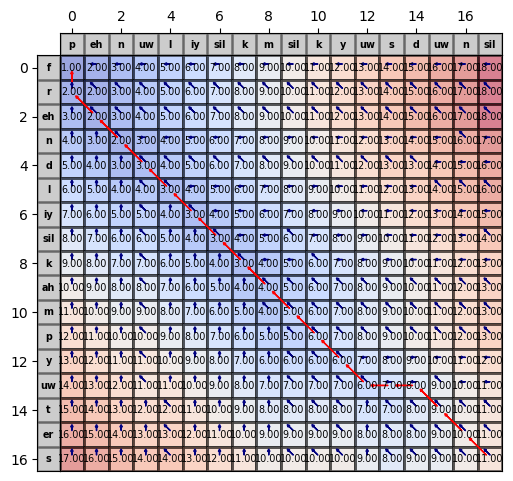

In [77]:
from pyspch import dtw
y = np.array(seg_phn['seg'])
x = np.array(y_reco_seg['seg'])
lev_dist,trace,ld,cd,bptrs = dtw.dtw(x,y,trans="LEV",p='hamming',result='details')
print("Levenshtein Distance:  %d / %d " %(lev_dist,len(y)))
print("Phone Error Rate:  %.2f%% " %(100.*lev_dist/len(y)))
print(y), print(x)
plt_args = {'ftr_scale':.05,'fig_width':6.,'ftr_args':{'alpha':.2,'cmap':'Greys','fontweight':'bold'}, 
           'xy_annot':True,'xy_args':{'cmap':'coolwarm','alpha':.5,'text_size':'x-small'} }
display(dtw.plot_trellis(x=x,y=y,xy_mat=cd,trace=trace,bptrs=bptrs,**plt_args))

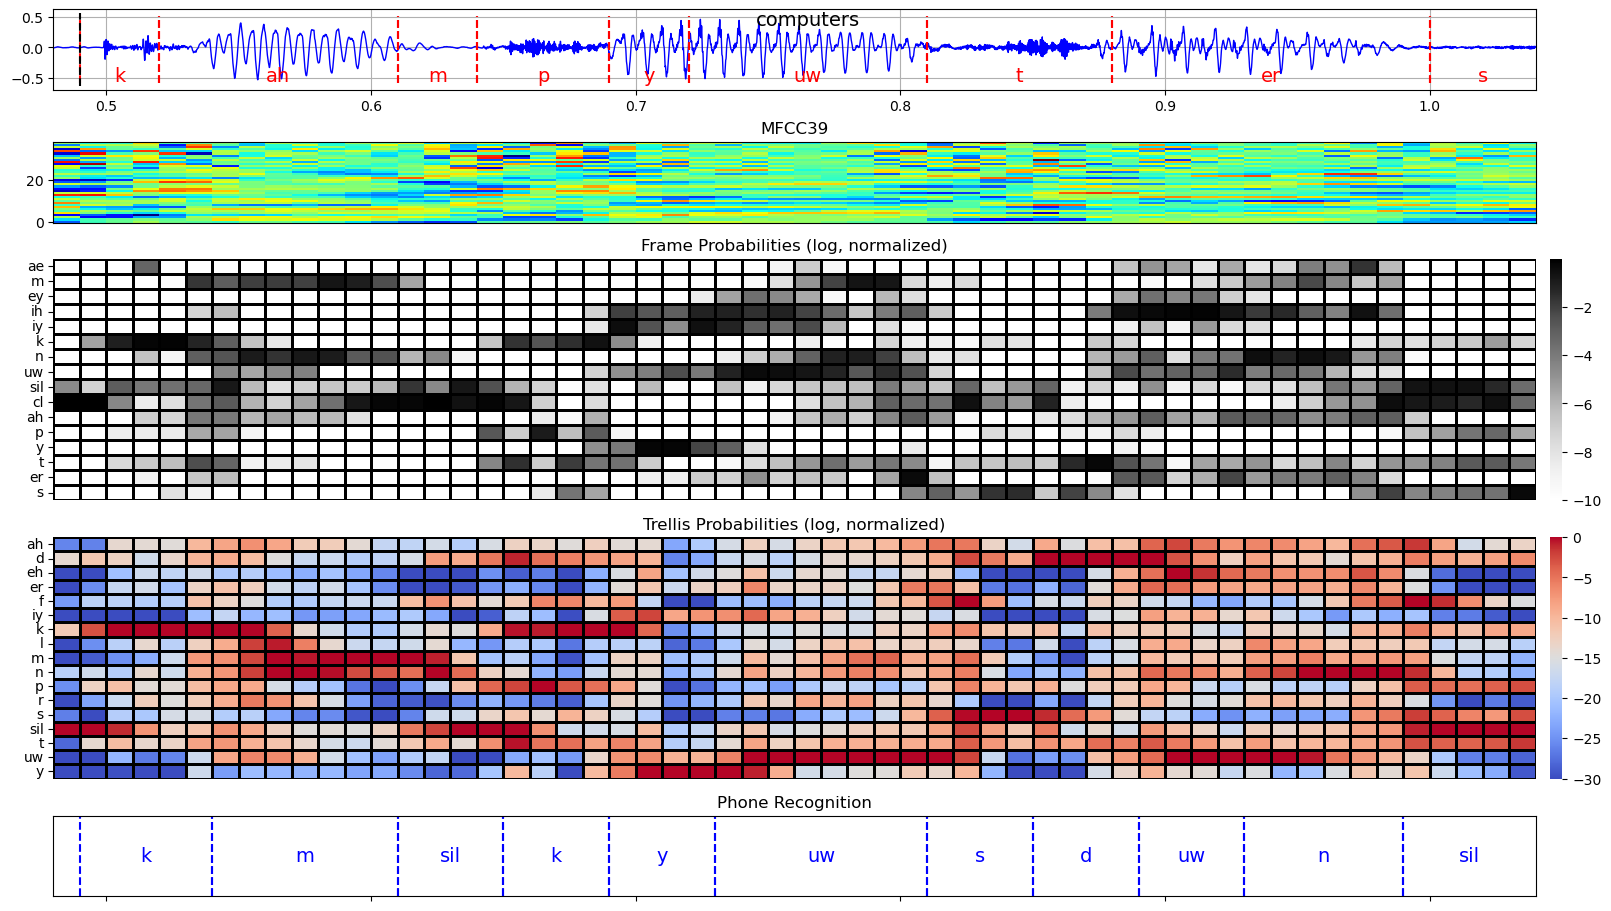

In [78]:
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,1],
            frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftr, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r',size=14) 
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
fig.axes[iax_ftr].set_title("MFCC39")
fig.axes[iax_ftr].set_xticks([])
#
log_probs = np.log(frame_proba) 
plot_probs(log_probs[frame_sel,indx_sel],phn_sel,vmin=-10.,fig=fig, cmap='Greys',iax=iax_prob, style="img",title="Frame Probabilities (log, normalized)") 
#
trel_probs = trellis2.probs
plot_probs(trel_probs[frame_sel,:],labels=trel_phones,vmin=-30.,fig=fig,cmap='coolwarm',iax=iax_trel,style="img",title="Trellis Probabilities (log, normalized)",
           annot=False)
#fig.add_seg_plot(y_reco_ldf,iax=iax_vit,ypos=.75,color='#000',size=10)
fig.add_seg_plot(y_reco_seg,iax=iax_vit,ypos=.5,color='#00F',size=14,title="Phone Recognition")
#fig.axes[iax_vit].set_ylabel('Recognition')
#
display(fig)

### Plot Selected Segments and Phones

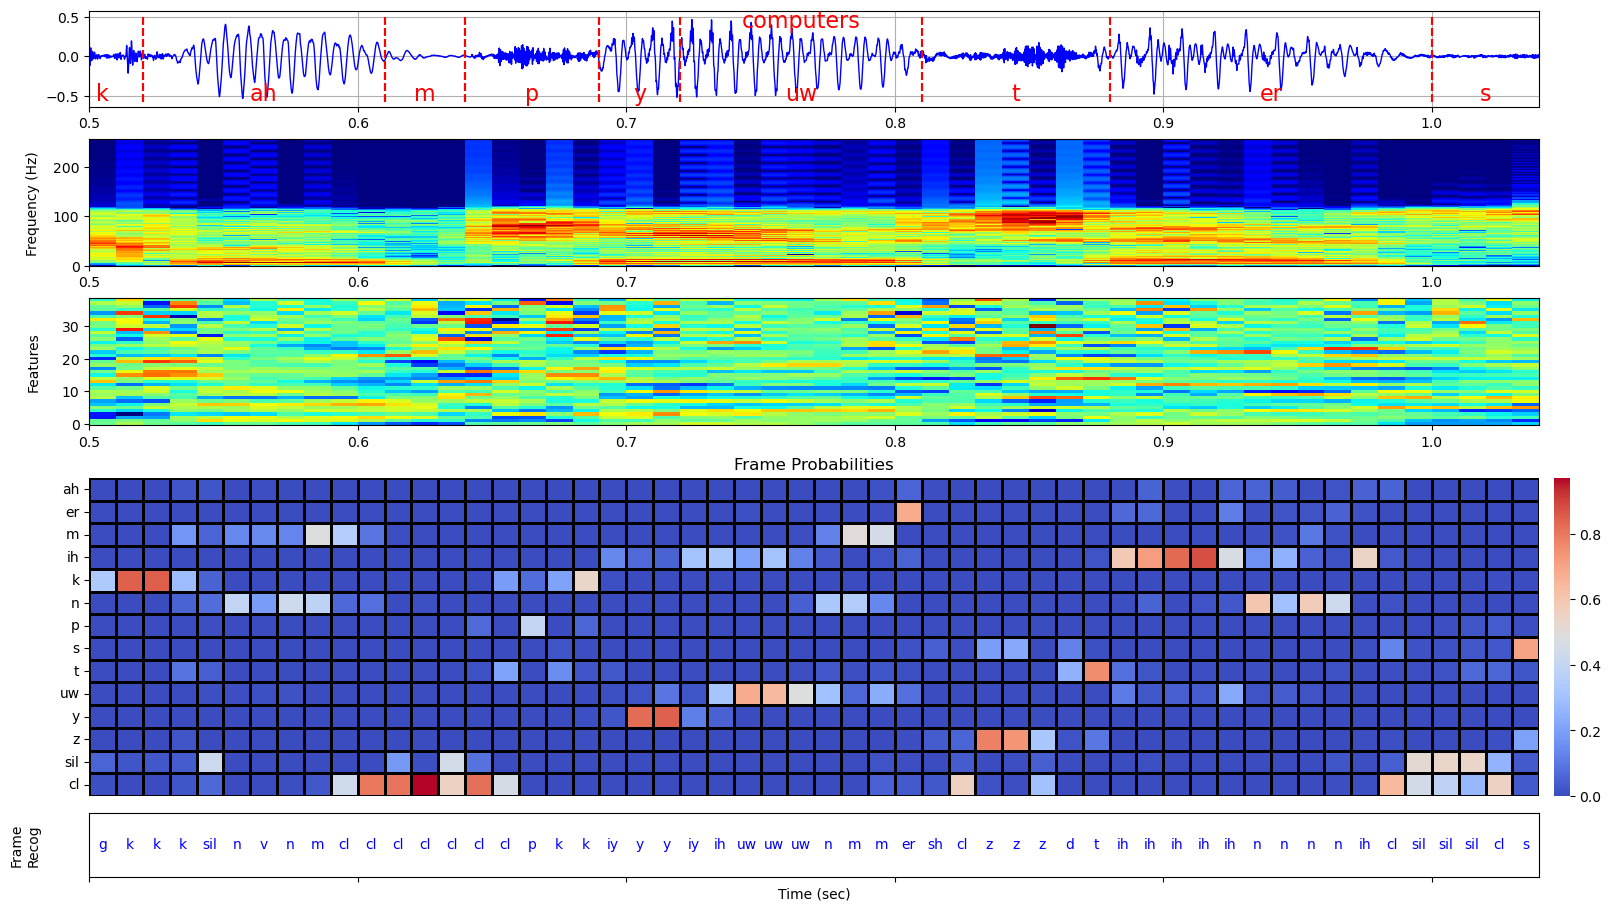

Frame Recognition Rate: 9/54 (16.67%)


In [25]:
# make a selection of phones to plot
# include the most likely outputs and the phones in the transcriptions
top_k = 10
indx_sel = np.argsort(np.sum(frame_proba[frame_sel,:],axis=0))[::-1][0:top_k]
phn_sel = [phn_set[i] for i in indx_sel]
phn_sel, indx_sel = select_phones_idx((seg_sel['seg'],phn_sel,['sil']),phn_set,SORTED=True)

# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,row_heights=[1.5,2,2,5,1],
            frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[ftrs,None,None],img_labels=['Features',None,None])
(iax_wav, iax_spg, iax_ftr, iax_prob, iax_frame, iax_ref) = (0,1,2,3,4,5)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='r') # seg
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, Lines=True, color='r')

plot_probs(frame_proba[frame_sel,indx_sel], phn_sel,fig=fig, cmap='coolwarm',iax=iax_prob, vmin=None, x0=frames[0]*shift, style="img", title="Frame Probabilities")
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10)
fig.axes[iax_frame].set_ylabel('Frame\nRecog')

display(fig)
n_corr = np.sum([y_frame_lab[i] == labels[i] for i in range(frames[0],frames[1])])
n_frames = (frames[1]-frames[0])
print("Frame Recognition Rate: %d/%d (%.2f%%)" % (n_corr,n_frames,100.*n_corr/n_frames))

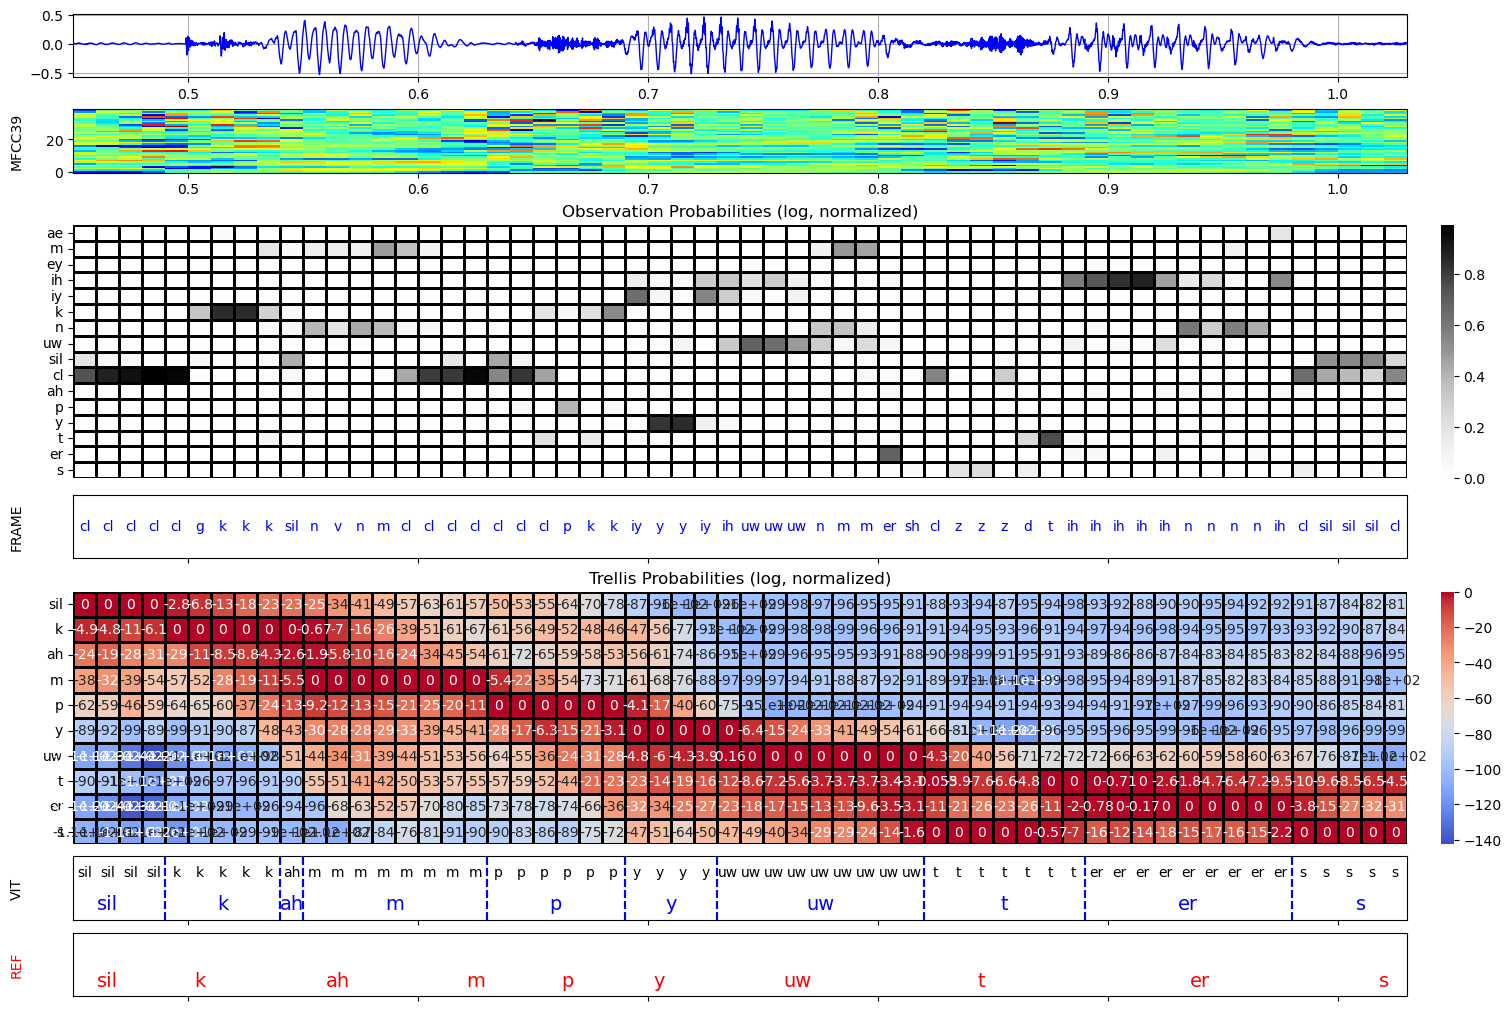

In [70]:



fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=ftrs,spglabel="MFCC39",dy=1,frames=frames,sample_rate=sr,figsize=(15,10),row_heights=[1,1,4,1,4,1,1],
                  img_ftrs=[None,None,None])
(iax_wav, iax_spg, iax_prob, iax_frame, iax_trel, iax_vit, iax_ref) = (0,1,2,3,4,5,6)
obs_probs = np.log(frame_proba) 
obs_probs = frame_proba
trel_probs = trellis1.probs
plot_probs(obs_probs[frame_sel,indx_sel],fig=fig,iax=iax_prob,labels=phn_sel,cmap="Greys",style="img",title="Observation Probabilities (log, normalized)")
plot_probs(trel_probs[frame_sel,state_sel],fig=fig,cmap='coolwarm',labels=transcript_sel,iax=iax_trel,style="img",title="Trellis Probabilities (log, normalized)",annot=True)
#fig.add_seg_plot(seg_wrd,iax=0,ypos=0.8,color='k')

#fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b',title='Viterbi Alignment')

fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#00F',size=10)
fig.add_seg_plot(y_vit_ldf,iax=iax_vit,ypos=.75,color='#000',size=10)
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.25,color='#00F',size=14)
fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=.25,color='r',size=14,Lines=False)
fig.axes[iax_frame].set_ylabel('FRAME')
fig.axes[iax_vit].set_ylabel('VIT')
fig.axes[iax_ref].set_ylabel('REF',color='r')
fig.axes[iax_frame].set_xlabel("")
#fig.add_seg_plot(seg_phn,iax=iax_ref,ypos=0.2,color='b',title='Reference Alignment')
display(fig)


In [21]:
pd.set_option('display.float_format', '{:.2f}'.format)
i1 = 50
i2 = 60
obs_probs = frame_ll
obs_probs = frame_ll-np.max(frame_ll,axis=1,keepdims=True)
dfo1 = pd.DataFrame(obs_probs[i1:i2,indx_sel].T,index=phn_sel,columns=np.arange(i1,i2))
dft1 = pd.DataFrame(trel_probs[i1:i2,state_sel].T,index=transcript_sel,columns=np.arange(i1,i2))
dfo2 = pd.DataFrame(obs_probs[i1:i2,:].T,index=phn_set,columns=np.arange(i1,i2))
dft2 = pd.DataFrame(trel_probs[i1:i2,:].T,index=transcript,columns=np.arange(i1,i2))

In [22]:
display(dfo1, dft1)

,50,51,52,53,54,55,56,57,58,59
ah,-14.69,-11.12,-8.07,-5.93,-1.71,-2.50,-4.40,-2.66,-1.49,-4.88
hh,-14.12,-15.29,-11.85,-12.81,-6.28,-11.96,-14.79,-14.41,-13.96,-12.05
ih,-20.75,-19.39,-18.82,-12.44,-9.01,-11.54,-13.15,-10.98,-8.02,-11.06
iy,-24.71,-25.11,-22.59,-15.23,-11.26,-14.77,-19.05,-23.03,-17.69,-17.05
k,0.00,0.00,0.00,0.00,-0.10,-5.73,-8.89,-7.32,-12.72,-15.18
n,-18.43,-15.66,-16.63,-8.57,-2.18,-4.40,-3.13,-5.08,-1.38,-6.04
p,-6.46,-9.75,-6.12,-9.50,-9.69,-11.88,-13.36,-16.00,-18.17,-19.89
uw,-25.30,-22.91,-20.82,-14.26,-8.83,-9.36,-11.70,-7.61,-9.32,-9.51
sil,-9.36,-8.00,-5.95,-8.82,-4.74,-7.87,-4.83,-6.32,-10.13,-11.19
cl,-6.15,-9.02,-7.29,-9.48,-7.73,-6.55,-3.77,-5.92,-4.26,-6.17


,50,51,52,53,54,55,56,57,58,59
sil,-26.25,-28.74,-21.42,-18.01,-15.29,-6.17,-10.67,-11.98,-16.55,-18.66
k,-26.45,-27.41,-19.88,-18.05,-8.36,0.00,0.00,-0.67,-0.77,0.00
ah,-25.16,-26.28,-24.46,-19.51,-12.67,-4.63,-9.22,-10.36,-11.53,-10.09
m,-14.60,-16.37,-15.96,-17.23,-15.71,-11.05,-17.84,-19.10,-23.87,-22.66
p,-26.06,-25.44,-21.26,-21.11,-15.36,-13.25,-15.37,-22.87,-17.48,-21.02
y,-26.97,-25.02,-26.26,-23.37,-19.78,-17.24,-26.01,-20.81,-27.08,-24.88
uw,-16.48,-22.81,-19.90,-24.01,-17.21,-11.33,-14.11,-15.28,-19.33,-18.15
t,-18.22,-19.54,-19.88,-21.56,-19.69,-15.11,-21.16,-17.36,-19.07,-19.88
er,-30.99,-38.00,-24.32,-22.34,-15.45,-7.02,-13.95,-19.08,-14.57,-14.66
s,-27.79,-30.24,-26.31,-26.64,-19.84,-15.75,-21.70,-24.13,-22.47,-23.15


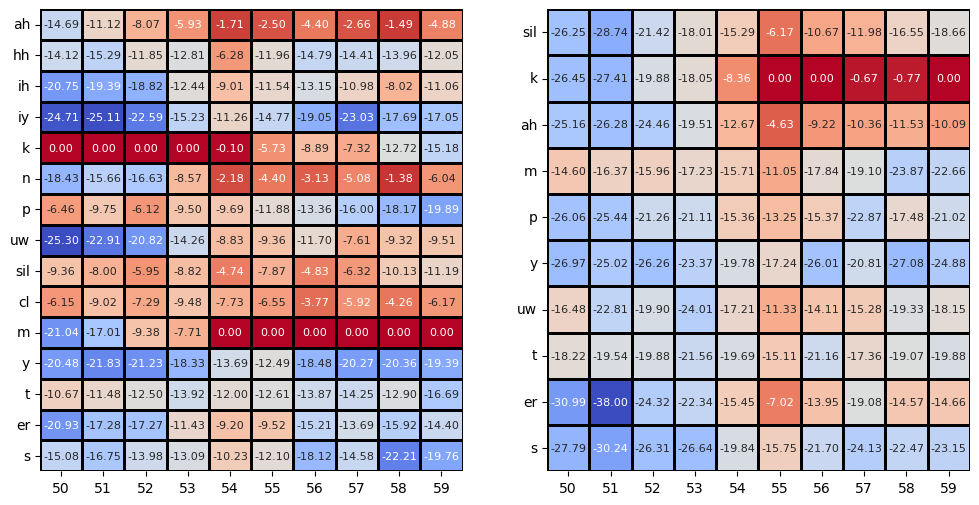

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

kwargs = {"cmap":"coolwarm","fmt":".2f","linewidths":1,"linecolor":'k',"annot":True,"annot_kws":{"fontsize":8},'cbar':False,'square':False}
sns.heatmap(dfo1,ax=ax[0],**kwargs)
sns.heatmap(dft1,ax=ax[1],**kwargs)
#cmap="coolwarm",fmt=".2f",linewidths=1,linecolor='k',annot=True) #, ax=ax, yticklabels=labels, cmap=cmap,vmin=vmin,,cbar_kws={'pad':0.0})
for axx in ax: axx.set_yticklabels(axx.get_yticklabels(), rotation=0)
#ax.set_xticks([])

In [ ]:
dft1

In [ ]:
phn_sel

In [ ]:
obs_probs.shape,trel_probs[-30:,-5:]

In [ ]:
ph2indx